In [39]:
import math

def ob_buy_metric(price, timestamp, iob_btm, iob_top, iob_created):
    if iob_top < iob_btm:
        iob_top, iob_btm = iob_btm, iob_top

    ob_mid = (iob_top + iob_btm) / 2
    ob_range = iob_top - iob_btm
    half_range = ob_range / 2

    # INSIDE OB — parabolic curve, always >= 0.5
    if iob_btm <= price <= iob_top:
        x = abs(price - ob_mid) / half_range   # 0 → 1
        position_score = 0.5 + 0.5 * (1 - x*x)

    # OUTSIDE OB — exponential decay from 0.5
    else:
        distance = min(abs(price - iob_top), abs(price - iob_btm))
        k = 3 / ob_range
        position_score = 0.5 * math.exp(-k * distance)

    # AGE penalty (unchanged)
    age_seconds = timestamp - iob_created
    # age_factor = math.exp(-math.log(2) * age_seconds / decay_half_life)

    return max(0, min(1, position_score))  # * age_factor


In [42]:
def ob_buy_metric(price, timestamp, iob_btm, iob_top, iob_created, decay_half_life=30*24*3600):
    """
    Calculate a desirability metric (0 to 1) for buying based on order block proximity and recency.

    Parameters:
        price (float): current asset price
        timestamp (int): current time in timestamp (seconds)
        iob_btm (float): bottom price of bullish order block
        iob_top (float): top price of bullish order block
        iob_created (int): timestamp (seconds) when the OB was created
        decay_half_life (float): seconds until the OB influence halves (default: 30 days)

    Returns:
        float: desirability metric (0 = poor, 1 = excellent)
    """
    # --- normalize order block range ---
    if iob_top < iob_btm:
        iob_top, iob_btm = iob_btm, iob_top

    ob_mid = (iob_top + iob_btm) / 2
    ob_range = iob_top - iob_btm
    if ob_range == 0:
        return 0.0

    # --- position-based score ---
    if iob_btm <= price <= iob_top:
        # inside OB → high score (max at middle)
        position_score = 1 - abs(price - ob_mid) / (ob_range / 2)
    else:
        # outside OB → exponential decay based on distance
        distance = min(abs(price - iob_top), abs(price - iob_btm))
        position_score = math.exp(-3 * distance / ob_range)

    # --- recency-based weight ---
    age_seconds = timestamp - iob_created
    age_factor = math.exp(-math.log(2) * age_seconds / decay_half_life)  # half-life decay

    # --- final metric ---
    metric = position_score * age_factor
    return max(0.0, min(1.0, metric))

In [33]:
x = abs(10.001 - 11) / 1
position_score = 0.5 + 0.5 * math.cos(math.pi * x)
position_score

2.467399070893439e-06

In [24]:
print(ob_buy_metric(12.9, 0, 10, 12, 0))

0.1296201303229457


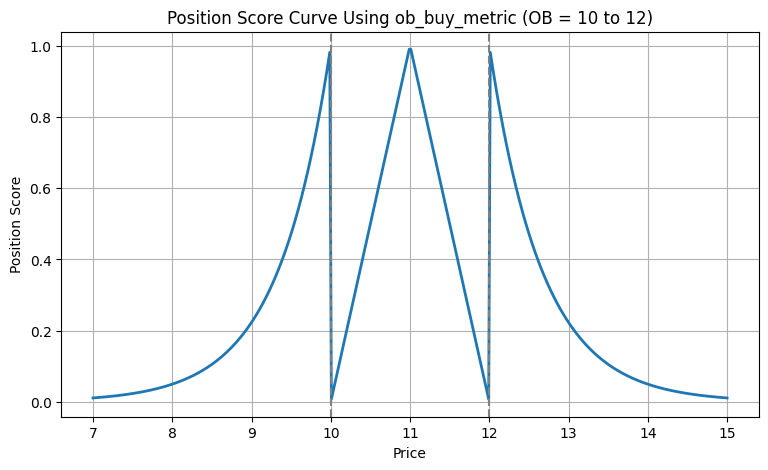

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Example OB
iob_btm = 10
iob_top = 12
iob_created = 0
timestamp = 0

# price range to visualize
prices = np.linspace(7, 15, 400)

# compute scores using YOUR ob_buy_metric function
scores = [ob_buy_metric(p, timestamp, iob_btm, iob_top, iob_created) for p in prices]

plt.figure(figsize=(9,5))
plt.plot(prices, scores, linewidth=2)
plt.axvline(iob_btm, color='gray', linestyle='--')
plt.axvline(iob_top, color='gray', linestyle='--')
plt.title("Position Score Curve Using ob_buy_metric (OB = 10 to 12)")
plt.xlabel("Price")
plt.ylabel("Position Score")
plt.grid(True)
plt.show()


In [44]:
def score_divergence(bd_dict: dict):
    """
    Computes an auto-weighted divergence score (0−1) using only bd_dict.

    bd_dict format:
        {
            'rsi':  [True, False, True, False],
            'macd': [False, True, True, False],
            ...
        }

    Design:
    - Equal weights across metrics
    - Recency-weighted swings: w[i] = (N - i) / sum(1..N)
      meaning newest swings contribute most
    - Score ∈ [0, 1]
    """

    if not bd_dict or not isinstance(bd_dict, dict):
        return 0.0

    metrics = list(bd_dict.keys())
    num_metrics = len(metrics)
    if num_metrics == 0:
        return 0.0

    list_len = len(bd_dict[metrics[0]])
    if list_len == 0:
        return 0.0

    # --- Equal metric weights ---
    metric_weight = 1.0 / num_metrics

    # --- Recency-based swing weights ---
    # Newest (index 0) has highest weight
    # w[i] = (N - i) / sum(1..N)
    denominator = sum(range(1, list_len + 1))
    swing_weights = [(list_len - i) / denominator for i in range(list_len)]

    # --- Compute score ---
    weighted_sum = 0.0
    total_weight = 0.0

    for mt in metrics:
        results = bd_dict[mt]

        for i in range(list_len):
            val = 1.0 if results[i] else 0.0
            weight = metric_weight * swing_weights[i]

            weighted_sum += val * weight
            total_weight += weight

    if total_weight == 0:
        return 0.0

    return float(weighted_sum / total_weight)


In [50]:
score_divergence(
    {
        "mfi": [True, False, False],
        "stoch": [False, False, True],
        "d": [True, False, False]
    }
)

0.38888888888888884